In [1]:
# Cell to allow importation of script in parent folder
import sys
import os

current_dir = os.path.dirname(__file__) if '__file__' in globals() else os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, "../")))

# EASE

This notebook demonstrates the EASE model, proposed in [this paper](https://arxiv.org/pdf/1905.03375), as a recommender system.


In [2]:
from ease import EASE
from data_formatting import DataFormatting
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

## Data

We start by loading the data and formatted it in sparse matrix for memory efficiency and computation optimization.

In [3]:
# Train dataset
data = DataFormatting('../data/train.csv')
X, maps = data.create_matrix_csr()

# Test dataset
test_df = pd.read_csv("../data/test.csv")

## Model

We can now simply compute the weight matrix using the closed solution proposed by the author of the above-mentioned paper.

In [4]:
ease = EASE(X=X, maps=maps)
ease.fit()

Computing the Gram-Matrix... [1/4]
Adding lambda to the diagonal of Gram-Matrix... [2/4]
Computing the inverse of Gram-Matrix... [3/4]
Compute the weight matrix... [4/4]

Training completed in 0:01:42.842925


Finnally, we compute the score prediction for each user-item pair. Also, convert the score into ratings using a linear solution that has its limitations since it doesn't modify the rating distribution, but has proven better Kaggle score than other complex linear or non-linear method such as Sigmoid transformation or ranking transformation.


In [5]:
ease.predict()

Starting to predict score of all (user,book) pairs...
Map score into a 1 to 4 score range...

Prediction completed in 0:00:05.242308


The distribution of scores and ratings is identical, as expected, since we are applying a linear transformation. However, note that we scale the scores to a range of 1 to 4 instead of 1 to 5. This adjustment helps avoid predicting too many values around 4 and 5, which are relatively infrequent and could significantly inflate the RMSE.

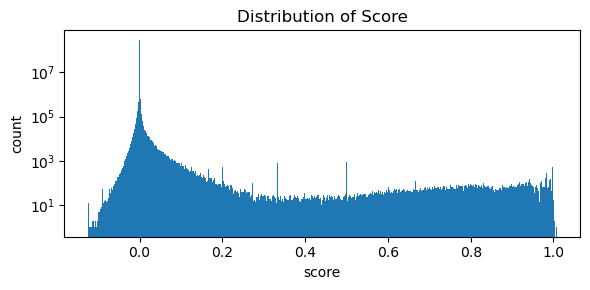

Mean of predicted scores: 0.0001


In [6]:
plt.figure(figsize=(6, 3))
plt.hist(ease.score.flatten(), bins=500)
plt.title("Distribution of Score")
plt.xlabel('score')
plt.ylabel('count')
plt.yscale('log')
plt.tight_layout()
plt.savefig("ease_score.pdf")
plt.show()

print(f"Mean of predicted scores: {ease.score.mean():.4f}")

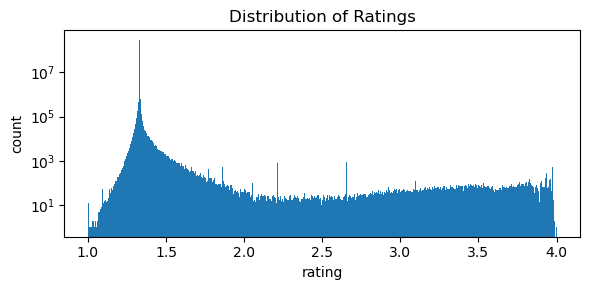

Mean of predicted ratings: 1.3313


In [7]:
plt.figure(figsize=(6, 3))
plt.hist(ease.rating.flatten(), bins=500)
plt.title("Distribution of Ratings")
plt.xlabel('rating')
plt.ylabel('count')
plt.yscale('log')
plt.tight_layout()
plt.savefig("ease_rating.pdf")
plt.show()

print(f"Mean of predicted ratings: {ease.rating.mean():.4f}")

Retrieve the wanted ratings and save them if satisfied.

In [8]:
ease.retrieve_pred(df=test_df)
ease.save_pred()

# Appendix

Just to recall the observed distribution of ratings in our `train.csv` dataset.

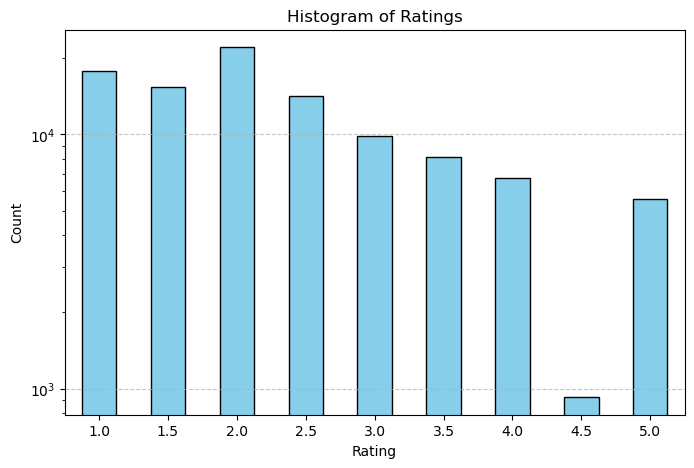

In [9]:
train_df = pd.read_csv('../data/train.csv')

# Convert to a DataFrame
rating_counts_df = pd.DataFrame.from_dict(Counter(train_df['rating']), orient='index', columns=['count']).sort_index()

# Plot the histogram
plt.figure(figsize=(8, 5))
rating_counts_df['count'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.yscale('log')
plt.title('Histogram of Ratings')
plt.xticks(ticks=range(len(rating_counts_df.index)), labels=rating_counts_df.index, rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()